Number of strikes (first expiry): 69

 Calibration Results
L-BFGS-B                   RMSE=0.19544  Time=0.05s  Params=[ 2.      0.7354 -0.6067  5.    ]
Differential Evolution     RMSE=0.19605  Time=0.44s  Params=[ 1.9324  0.7372 -0.6049  4.9988]
Hybrid DE→L-BFGS-B         RMSE=0.19544  Time=0.45s  Params=[ 2.      0.7354 -0.6067  5.    ]

Best method: Hybrid DE→L-BFGS-B


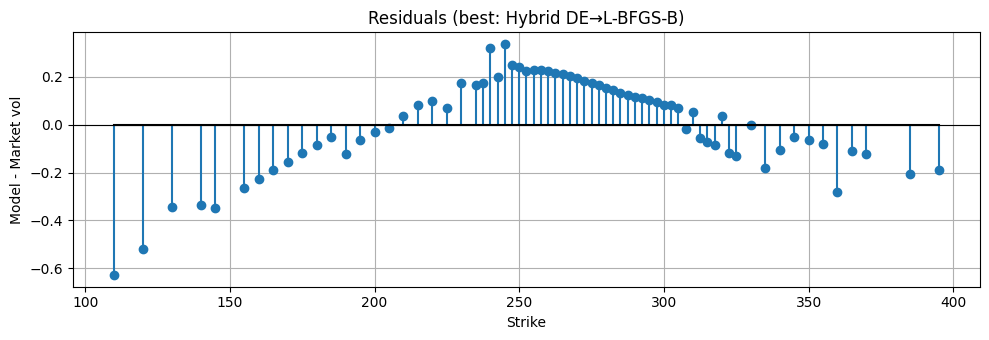

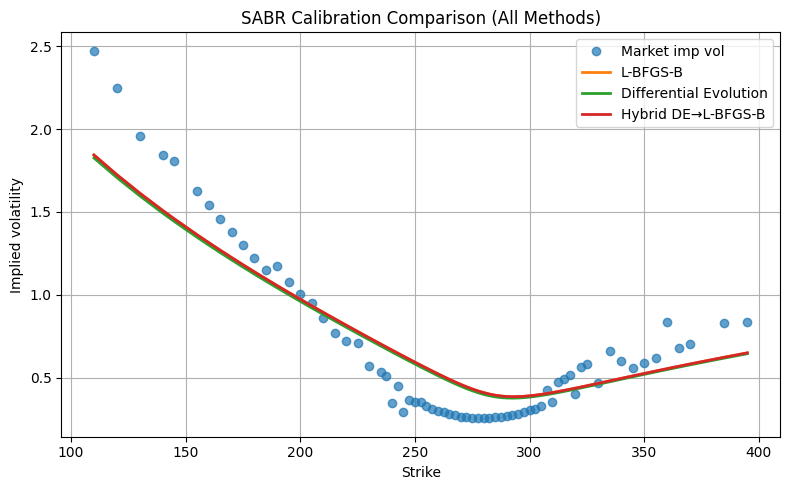

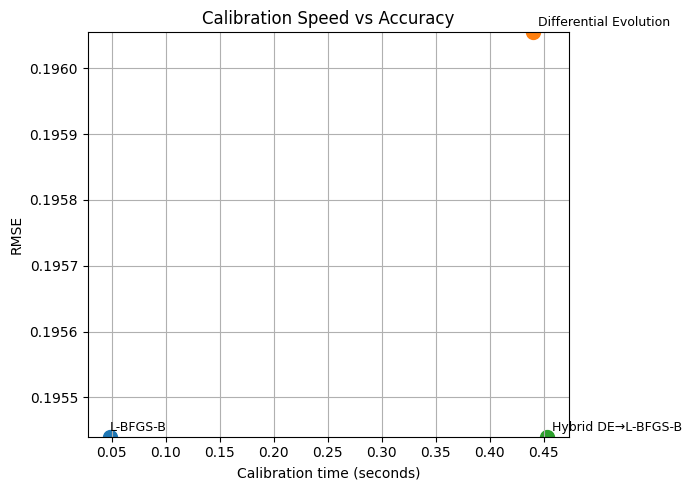

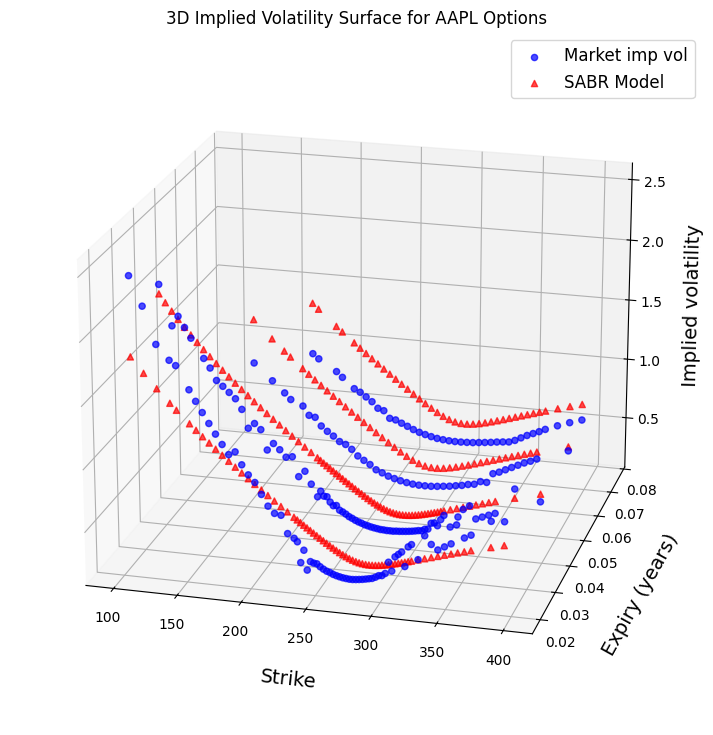

In [32]:
#Title: Fast and Accurate SABR Calibration for AAPL Options: A Hybrid Optimization Approach

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import yfinance as yf
from scipy.optimize import minimize, differential_evolution, brentq
from scipy.stats import norm


#Black-Scholes and implied volatility
def bsp(F, K, T, sigma, option_type="C"):
    if sigma <= 0 or T <= 0:
        return np.nan
    d1 = (np.log(F/K) + 0.5*sigma**2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == "C":
        return F * norm.cdf(d1) - K * norm.cdf(d2)
    else:
        return K * norm.cdf(-d2) - F * norm.cdf(-d1)
def impvol(F, K, T, price, option_type="C"):
    if price <= 0 or T <= 0 or F <= 0 or K <= 0:
        return np.nan
    try:
        func = lambda s: bsp(F, K, T, s, option_type) - price
        return brentq(func, 1e-6, 5.0)
    except Exception:
        return np.nan

#SABR implied vol (Hagan 2002 approximation)
def sabr_impvol(F, K, T, alpha, beta, rho, nu):
    if F <= 0 or K <= 0 or alpha <= 0 or T <= 0:
        return np.nan
    if F == K:
        term1 = alpha / (F ** (1 - beta))
        term2 = 1 + ((2 - 3 * rho**2) * nu**2 * T) / 24
        return term1 * term2
    logFK = np.log(F / K)
    FK_beta = (F * K) ** ((1 - beta) / 2)
    z = (nu / alpha) * FK_beta * logFK
    xz = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
    A = alpha / (FK_beta * (1 + ((1 - beta)**2 / 24) * logFK**2 + ((1 - beta)**4 / 1920) * logFK**4))
    B = z / xz
    correction = 1 + (((1 - beta)**2 / 24) * (alpha**2 / FK_beta**2) + (rho * beta * nu * alpha) / (4 * FK_beta) + ((2 - 3*rho**2)/24) * nu**2) * T
    return A * B * correction


#SABR calibration RMSE
def sabr_rmse(params, F, K, T, market_vols):
    alpha, beta, rho, nu = params
    if not (0 < beta <= 1) or not (-0.999 < rho < 0.999) or alpha <= 0 or nu <= 0:
        return 1e6
    model_vols = np.array([sabr_impvol(F, k, T, alpha, beta, rho, nu) for k in K])
    mask = np.isfinite(model_vols) & np.isfinite(market_vols)
    if np.sum(mask) < 3:
        return 1e6
    return np.sqrt(np.mean((model_vols[mask] - market_vols[mask])**2))


#download AAPL option data
def aapl_option_data(ticker="AAPL", max_expiries=5):
    tk = yf.Ticker(ticker)
    S = tk.history(period="1d")["Close"].iloc[-1]
    expirations = tk.options[:max_expiries]
    today = pd.Timestamp.utcnow().floor('D').tz_localize(None)
    all_data = []
    Ts = []
    for exp in expirations:
        chain = tk.option_chain(exp)
        calls = chain.calls.copy()
        if calls.empty:
            continue
        exp_date = pd.to_datetime(exp).tz_localize(None)
        T_days = max((exp_date - today).days, 0)
        if T_days <= 3:
            continue
        T = T_days / 365.0
        calls["mid"] = (calls["bid"] + calls["ask"]) / 2
        calls = calls[(calls["strike"] > 0) & (calls["mid"] > 0)]
        calls["iv"] = calls.apply(lambda r: impvol(S, r["strike"], T, r["mid"], "C"), axis=1)
        all_data.append(calls[["strike", "iv"]].copy())
        Ts.append(T)
    if len(all_data) == 0:
        raise ValueError("No valid option chain found for AAPL.")
    return S, Ts, all_data

#calibration methods
def calibrate_methods(F, K, T, vols):
    results = {}
    bounds = [(0.001, 2.0), (0.0, 1.0), (-0.999, 0.999), (0.001, 5.0)]
    x0 = [0.2, 0.5, 0.0, 0.5]

    #L-BFGS-B
    t0 = time.time()
    res1 = minimize(sabr_rmse, x0, args=(F, K, T, vols), bounds=bounds, method="L-BFGS-B")
    t1 = time.time()
    results["L-BFGS-B"] = (res1.x, res1.fun, t1 - t0)

    #differential evolution
    t0 = time.time()
    res2 = differential_evolution(sabr_rmse, bounds, args=(F, K, T, vols), polish=False, maxiter=200)
    t1 = time.time()
    results["Differential Evolution"] = (res2.x, res2.fun, t1 - t0)

    #hybrid DE → L-BFGS-B
    t0 = time.time()
    res_de = differential_evolution(sabr_rmse, bounds, args=(F, K, T, vols), polish=False, maxiter=150)
    res_lbfgs = minimize(sabr_rmse, res_de.x, args=(F, K, T, vols), bounds=bounds, method="L-BFGS-B")
    t1 = time.time()
    results["Hybrid DE→L-BFGS-B"] = (res_lbfgs.x, res_lbfgs.fun, t1 - t0)
    return results


#SABR calibration
S_multi, Ts, all_data = aapl_option_data(max_expiries=5)
S_single, T_single, df_single = S_multi, Ts[0], [all_data[0]]
K = df_single[0]["strike"].values
vols = df_single[0]["iv"].values
print(f"Number of strikes (first expiry): {len(K)}")
results = calibrate_methods(S_single, K, T_single, vols)
print("\n Calibration Results")
for k, (params, err, t) in results.items():
    print(f"{k:25s}  RMSE={err:.5f}  Time={t:.2f}s  Params={np.round(params,4)}")
best_method = min(results.items(), key=lambda x: x[1][1])[0]
best_params = results[best_method][0]
print(f"\nBest method: {best_method}")

#residuals plot
model_best = [sabr_impvol(S_single, k, T_single, *best_params) for k in K]
resids = np.array(model_best) - np.array(vols)
plt.figure(figsize=(10,3.5))
plt.stem(K, resids, markerfmt="o", basefmt="k-", linefmt="C0-")
plt.axhline(0, color="k", lw=0.8)
plt.title(f"Residuals (best: {best_method})")
plt.xlabel("Strike"); plt.ylabel("Model - Market vol")
plt.grid(True)
plt.tight_layout(); plt.show()

#SABR calibration comparison
plt.figure(figsize=(8,5))
plt.plot(K, vols, 'o', label="Market imp vol", alpha=0.7)
for method, (params, _, _) in results.items():
    model_vols = [sabr_impvol(S_single, k, T_single, *params) for k in K]
    plt.plot(K, model_vols, '-', lw=2, label=f"{method}")
plt.xlabel("Strike")
plt.ylabel("Implied volatility")
plt.title("SABR Calibration Comparison (All Methods)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#calibration speed vs accuracy
plt.figure(figsize=(7,5))
rmse_vals = [res[1] for res in results.values()]
min_rmse, max_rmse = min(rmse_vals), max(rmse_vals)
y_margin = (max_rmse - min_rmse) * 0.05 if max_rmse > min_rmse else 0.001
for method, (_, rmse, runtime) in results.items():
    plt.scatter(runtime, rmse, s=100, label=method)
    plt.text(runtime*1.01, rmse + y_margin*0.3, method, fontsize=9)
plt.xlabel("Calibration time (seconds)")
plt.ylabel("RMSE")
plt.title("Calibration Speed vs Accuracy")
plt.grid(True)
plt.margins(x=0.05, y=0)
plt.tight_layout()
plt.show()

#3D volatility surface
strikes, expiries, market_vols, model_vols = [], [], [], []
for i, df in enumerate(all_data):
    T = Ts[i]
    for k, iv in zip(df["strike"], df["iv"]):
        strikes.append(k)
        expiries.append(T)
        market_vols.append(iv)
        model_vols.append(sabr_impvol(S_multi, k, T, *best_params))
strikes = np.array(strikes)
expiries = np.array(expiries)
market_vols = np.array(market_vols)
model_vols = np.array(model_vols)
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(strikes, expiries, market_vols, c='blue', label='Market imp vol', marker='o', alpha=0.7)
ax.scatter(strikes, expiries, model_vols, c='red', label='SABR Model', marker='^', alpha=0.7)
ax.set_xlabel('Strike', fontsize=14, labelpad=15)
ax.set_ylabel('Expiry (years)', fontsize=14, labelpad=15)
ax.set_zlabel('Implied volatility', fontsize=14, labelpad=12, rotation=90)
ax.view_init(elev=20, azim=-75)
ax.legend(fontsize=12)
plt.title("3D Implied Volatility Surface for AAPL Options")
plt.show()
